<h1><span style="color:gray">ipyrad-analysis toolkit:</span> Dimensionality reduction</h1>

The `pca` tool can be used to implement a number of dimensionality reduction methods on SNP data (PCA, t-SNE, UMAP) and to filter and/or impute missing data in genotype matrices to reduce the effects of missing data. 

### Load libraries

In [1]:
# conda install ipyrad -c conda-forge -c bioconda
# conda install ipcoal -c conda-forge
# conda install scikit-learn -c conda-forge

In [2]:
import ipyrad.analysis as ipa
import toytree
import toyplot
import ipcoal

In [3]:
print(ipa.__version__)
print(toytree.__version__)
print(toyplot.__version__)
print(ipcoal.__version__)

0.9.61
2.0.4
0.19.0
0.1.5


### Simulate linked SNP data from this tree and write to a database (HDF5)
Here we simulate data on a tree/network that includes an introgressive edge. 

In [29]:
# make a random tree with root height in generations
tree = toytree.rtree.unittree(ntips=8, treeheight=5e5, seed=123)
tree.draw(ts='p', admixture_edges=(3, 4));

<svg class="toyplot-canvas-Canvas" height="260.0px" id="teac9231c408d4e69bd07eaa8b6fe62a3" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 260.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 r0 r1 r2 r3 r4 r5 r6 r7 0 250000 500000

In [30]:
# create a coalescent simulator w/ 8 samples per species and high Ne
model = ipcoal.Model(tree, Ne=2e5, nsamples=6, admixture_edges=(3, 4, 0.5, 0.15))

# simulate many short loci on coalescent genealogies (a few minutes)
model.sim_loci(nloci=2000, nsites=50)

# write simulated SNPs to a database file (.snps.hdf5)
model.write_snps_to_hdf5(name='test-pca', outdir="/tmp", diploid=True)

# now randomly drop data from many loci (RAD-seq like)
model.apply_missing_mask(coverage=0.75)

# write a data file with missingness in it (.snps.hdf5)
model.write_snps_to_hdf5(name='test-pca-cov75', outdir="/tmp", diploid=True)

wrote 11283 SNPs to /tmp/test-pca.snps.hdf5
wrote 10033 SNPs to /tmp/test-pca-cov75.snps.hdf5


### The input data

In [31]:
# the simulated SNP database file
SNPS = "/tmp/test-pca.snps.hdf5"

### Make an IMAP dictionary (map popnames to list of samplenames)

In [34]:
from itertools import groupby

# load sample names from SNPs file
tool = ipa.snps_extracter(SNPS)

# group names by prefix before '-'
groups = groupby(tool.names, key=lambda x: x.split("-")[0])

# arrange into a dictionary
IMAP = {i[0]: list(i[1]) for i in groups}

# show the imap dict
IMAP

{'r0': ['r0-0', 'r0-1', 'r0-2'],
 'r1': ['r1-0', 'r1-1', 'r1-2'],
 'r2': ['r2-0', 'r2-1', 'r2-2'],
 'r3': ['r3-0', 'r3-1', 'r3-2'],
 'r4': ['r4-0', 'r4-1', 'r4-2'],
 'r5': ['r5-0', 'r5-1', 'r5-2'],
 'r6': ['r6-0', 'r6-1', 'r6-2'],
 'r7': ['r7-0', 'r7-1', 'r7-2']}

### Run PCA
Unlinked SNPs are automatically sampled from each locus. By setting `nreplicates=30` the subsampling procedure is repeated 30X to show variation over the subsampled SNPs. The imap dictionary is used in the `.draw()` function to color points. 

In [57]:
# run on dataset with no missing data and with minor allele freq filter
tool = ipa.pca(data=SNPS, minmaf=0.03)

Samples: 24
Sites before filtering: 11283
Filtered (indels): 0
Filtered (bi-allel): 426
Filtered (mincov): 0
Filtered (minmap): 0
Filtered (subsample invariant): 0
Filtered (minor allele frequency): 4557
Filtered (combined): 4983
Sites after filtering: 6300
Sites containing missing values: 0 (0.00%)
Missing values in SNP matrix: 0 (0.00%)


In [58]:
# run to subsample unlinked SNPs and run PCA
tool.run(nreplicates=20)
tool.draw(imap=IMAP);

Subsampling SNPs: 1918/6300


<svg class="toyplot-canvas-Canvas" height="300.0px" id="tce29864bba2f406f827ba119d780a797" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 300.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0-0 r0-1 r0-2 r1-0 r1-1 r1-2 r2-0 r2-1 r2-2 r3-0 r3-1 r3-2 r4-0 r4-1 r4-2 r5-0 r5-1 r5-2 r6-0 r6-1 r6-2 r7-0 r7-1 r7-2 -10 0 10 20 PC0 (26.8%) explained -10 0 10 20 PC1 (13.2%) explained r0 r1 r2 r3 r4 r5 r6 r7

In [59]:
# a convenience function for plotting across three axes
tool.draw_panels(0, 1, 2, imap=IMAP);

<svg class="toyplot-canvas-Canvas" height="300.0px" id="t8b0b433375794e55a96899d7a25ddf01" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 1000.0 300.0" width="1000.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0-0 r0-1 r0-2 r1-0 r1-1 r1-2 r2-0 r2-1 r2-2 r3-0 r3-1 r3-2 r4-0 r4-1 r4-2 r5-0 r5-1 r5-2 r6-0 r6-1 r6-2 r7-0 r7-1 r7-2 -10 0 10 20 PC0 (26.8%) explained -10 0 10 20 PC1 (13.2%) explained <g class="toyplo

### Run TSNE
t-SNE is a manifold learning algorithm that can sometimes better project data into a 2-dimensional plane. The distances between points in this space are harder to interpret. You can see in this example that the gene flow between r3 and r4 is not readily apparent.

In [87]:
# run tsne on same dataset (try several perplexity values)
tool.run_tsne(perplexity=4, seed=333)
tool.draw(imap=IMAP, size=8);

Subsampling SNPs: 1918/6300


<svg class="toyplot-canvas-Canvas" height="300.0px" id="t71053b9b68ec4044b8c43081a8052e0f" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 300.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0-0 r0-1 r0-2 r1-0 r1-1 r1-2 r2-0 r2-1 r2-2 r3-0 r3-1 r3-2 r4-0 r4-1 r4-2 r5-0 r5-1 r5-2 r6-0 r6-1 r6-2 r7-0 r7-1 r7-2 -200 -100 0 100 TSNE component 1 -200 -100 0 100 TSNE component 2 r0 r1 r2 r3 r4 r5 r6 r7

### Run UMAP
UMAP is similar to t-SNE but the distances between clusters are more representative of the differences betwen groups. This requires another package that if it is not yet installed it will ask you to install. 

In [86]:
# try several n_neighbors values
tool.run_umap(subsample=False, n_neighbors=13, seed=222)
tool.draw(imap=IMAP, size=8);

<svg class="toyplot-canvas-Canvas" height="300.0px" id="t76d60466300443a49fe61bb55328982c" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 300.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0-0 r0-1 r0-2 r1-0 r1-1 r1-2 r2-0 r2-1 r2-2 r3-0 r3-1 r3-2 r4-0 r4-1 r4-2 r5-0 r5-1 r5-2 r6-0 r6-1 r6-2 r7-0 r7-1 r7-2 18 20 22 24 UMAP component 1 2 3 4 5 6 UMAP component 2 r0 r1 r2 r3 r4 r5 r6 r7

### Dealing with missing data (filtering and imputation)
Missing data has large effects on dimensionality reduction methods, and it is best to (1) minimize the amount of missing data in your input data set by using filtering, and (2) impute missing data values. In the example below we use the simulated datset with 25%  missing data and use filtering and imputation methods in the ipyrad-analysis tool. This allows us to make inferences from large SNP datasets despite missing data. 

Below the `pca` tool uses `impute_method=sample` to sample alleles for missing values based on the frequency of alleles at that SNP in the population (defined by the IMAP dictionary). It also drops any sites that do not have data across at least 50% of samples (mincov=0.5). 

In [92]:
# init a tool with the missing data dataset
tool2 = ipa.pca(
    data="/tmp/test-pca-cov75.snps.hdf5",
    imap=IMAP, 
    minmap={i: 1 for i in IMAP}, 
    mincov=0.5,
    minmaf=0.03,
    impute_method="sample", 
)

Samples: 24
Sites before filtering: 10033
Filtered (indels): 0
Filtered (bi-allel): 303
Filtered (mincov): 0
Filtered (minmap): 7
Filtered (subsample invariant): 0
Filtered (minor allele frequency): 3151
Filtered (combined): 3458
Sites after filtering: 6575
Sites containing missing values: 5116 (77.81%)
Missing values in SNP matrix: 9513 (6.03%)
Imputation: 'sampled'; (0, 1, 2) = 81.9%, 5.9%, 12.3%


The results below are nearly identical to the results above where there was 0% missing data, showing that filtering and imputation worked properly. 

Subsampling SNPs: 1918/6300


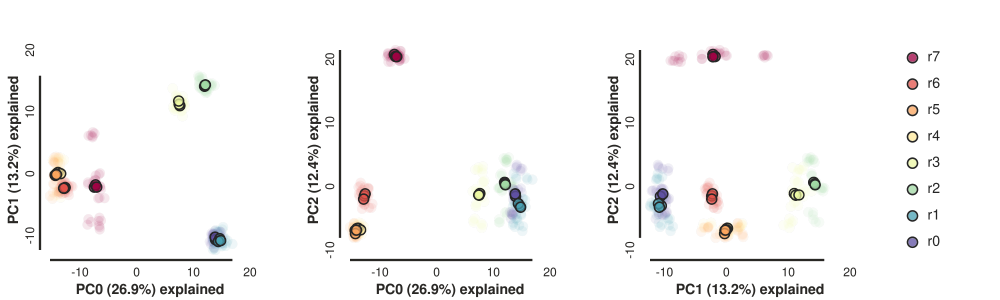

In [93]:
tool.run(nreplicates=10)
tool.draw_panels(imap=IMAP)

### Imputing without a priori groups

### What happens if you don't impute
Even a small amount of missing values (e.g., 5%) will cause significant bias if you arbitrarily set it to the ancestral state (0) instead of imputing. This example uses the `impute_method=None` and you can see the difference from the results above. I do not recommend using this setting.

In [95]:
# init a tool with the missing data dataset
tool3 = ipa.pca(
    data="/tmp/test-pca-cov75.snps.hdf5",
    imap=IMAP, 
    minmap={i: 1 for i in IMAP}, 
    mincov=0.5,
    minmaf=0.03,
    impute_method=None, 
)

Samples: 24
Sites before filtering: 10033
Filtered (indels): 0
Filtered (bi-allel): 303
Filtered (mincov): 0
Filtered (minmap): 7
Filtered (subsample invariant): 0
Filtered (minor allele frequency): 3151
Filtered (combined): 3458
Sites after filtering: 6575
Sites containing missing values: 5116 (77.81%)
Missing values in SNP matrix: 9513 (6.03%)
Imputation (null; sets to 0): 100.0%, 0.0%, 0.0%


In [19]:
tool.run_umap(n_neighbors=6)
tool.draw();

Subsampling SNPs: 6647/55885


<svg class="toyplot-canvas-Canvas" height="300.0px" id="t02354f41d48649faada8114b0a4cdb7e" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 300.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0-0 r0-1 r0-2 r0-3 r1-0 r1-1 r1-2 r1-3 r2-0 r2-1 r2-2 r2-3 r3-0 r3-1 r3-2 r3-3 r4-0 r4-1 r4-2 r4-3 r5-0 r5-1 r5-2 r5-3 r6-0 r6-1 r6-2 r6-3 r7-0 r7-1 r7-2 r7-3 -5 0 5 10 15 20 UMAP component 1 0 10 20 30 UMAP component 2 r0 r1 r2 r3 r4 r5 r6 r7